## load llm model

In [1]:
"""Inference for FastChat models."""
import abc
import gc
import json
import math
import os
import sys
import time
from typing import Iterable, Optional, Dict
import warnings

import psutil
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    LlamaTokenizer,
    LlamaForCausalLM,
    AutoModel,
    AutoModelForSeq2SeqLM,
    T5Tokenizer,
    AutoConfig,
)
from transformers.generation.logits_process import (
    LogitsProcessorList,
    RepetitionPenaltyLogitsProcessor,
    TemperatureLogitsWarper,
    TopKLogitsWarper,
    TopPLogitsWarper,
)

# from fastchat.conversation import get_conv_template, SeparatorStyle
# from fastchat.model.model_adapter import (
#     load_model,
#     get_conversation_template,
#     get_generate_stream_function,
# )
# from fastchat.modules.gptq import GptqConfig
# from fastchat.modules.awq import AWQConfig
# from fastchat.utils import is_partial_stop, is_sentence_complete, get_context_length

# 忽略指定的警告信息
warnings.filterwarnings("ignore", category=UserWarning, message=".*TypedStorage is deprecated.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*do_sample.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*temperature.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*top_p.*")

model_path = '/home/ai/Code/FastChat/lmsys/vicuna-7b-v1.5'
# num_gpus=2
load_8bit = False
torch.cuda.set_device(0)
device = 'cuda'
cpu_offloading = False
# gptq_config = GptqConfig(ckpt='/home/ai/Code/FastChat/lmsys/vicuna-7b-v1.5', wbits=16, groupsize=-1, act_order=False)
# awq_config = AWQConfig(ckpt='/home/ai/Code/FastChat/lmsys/vicuna-7b-v1.5', wbits=16, groupsize=-1)

# model, tokenizer = load_model(
#         model_path,
#         device=device,
#         num_gpus=num_gpus,
#         max_gpu_memory='7GiB',
#         load_8bit=load_8bit,
#         cpu_offloading=cpu_offloading,
#         gptq_config=gptq_config,
#         awq_config=awq_config,
#         revision='main',
#         debug=True,
# )

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    low_cpu_mem_usage=True,
)
tokenizer = AutoTokenizer.from_pretrained(
    model_path, use_fast=False, revision='main'
)
model.to(device)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
 

## define some data function

In [2]:
import unicodedata
import re
from w3lib.html import remove_tags
import pickle
from tqdm import tqdm

dataset_dir = '../FastChat/data_com'
save_tokens_file = "../FastChat/Eurp.pkl"
save_sentences_file = "../FastChat/Eurp_sentences.pkl"
not_possible_tokens_file = "../FastChat/not_possible_tokens"

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def normalize_string(s):
    pattern = r'>\s*(.*?)\n'
    # normalize unicode characters
    s = unicode_to_ascii(s)
    # remove the XML-tags
    # s = remove_tags(s)
    # add white space before !.?
    # s = re.sub(r'([!.?])', r' \1', s)
    # s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
    # s = re.sub(r'\s+', r' ', s)
    s = re.findall(pattern,s)
    # change to lower letter  没有改小写，改写不符合使用常理
    # s = s.lower()
    return s


def cutted_data(cleaned, MIN_LENGTH=60, MAX_LENGTH=70):
    cutted_lines = list()
    for line in cleaned:
        length = len(line.split())
        if length > MIN_LENGTH and length < MAX_LENGTH:
            line = [word for word in line.split()]
            cutted_lines.append(' '.join(line))
    return cutted_lines

def save_clean_sentences(sentence, save_path):
    pickle.dump(sentence, open(save_path, 'wb'))
    print('Saved: %s' % save_path)

def process(text_path):
    fop = open(text_path, 'r', encoding='utf8')
    raw_data = fop.read()
    # sentences = raw_data.strip().split('\n')
    # raw_data_input = [normalize_string(data) for data in sentences]
    sentences = normalize_string(raw_data)
    raw_data_input = sentences
    raw_data_input = cutted_data(raw_data_input)
    fop.close()
    return raw_data_input

if os.path.exists(save_tokens_file) and os.path.exists(save_sentences_file):
    with open(save_tokens_file, "rb") as file:
        tx_tokens = pickle.load(file)
    with open(save_sentences_file, "rb") as file:
        sentences = pickle.load(file)
else:     
    files = os.listdir(dataset_dir)
    sentences = []
    for fn in tqdm(files):
        if not fn.endswith('.txt'): continue
        process_sentences = process(os.path.join(dataset_dir, fn))
        sentences += process_sentences
    print('the number of sentences:',len(sentences))
    # remove the same sentences
    a = {}
    for aa in sentences:
        if aa not in a:
            a[aa] = 0
        a[aa] += 1
    sentences = list(a.keys())
    print('Number of clean sentences: {}'.format(len(sentences)))
    tx_tokens = []
    for seq in tqdm(sentences):
        tokens = tokenizer(seq,return_tensors="pt").input_ids.squeeze(0)
        tx_tokens.append(tokens)
    with open(save_tokens_file, 'wb') as f:
        pickle.dump(tx_tokens, f)
    with open(save_sentences_file, 'wb') as f:
        pickle.dump(sentences, f)
print('The numbers of tx sentences:',len(tx_tokens))
# find not possible tokens
if os.path.exists(not_possible_tokens_file):
    with open(not_possible_tokens_file, "rb") as file:
        not_possible_tokens = pickle.load(file)
else:
    all_tokens = set()
    for token_list in tx_tokens:
        all_tokens.update(token_list.tolist())    
    all_possible_tokens = set(range(32000))
    not_possible_tokens = all_possible_tokens - all_tokens
    not_possible_tokens = list(not_possible_tokens)
    not_possible_tokens.append(1)
    with open(not_possible_tokens_file, 'wb') as f:
        pickle.dump(not_possible_tokens, f)
print('the numbers of not possible tokens:',len(not_possible_tokens))

The numbers of tx sentences: 63650
the numbers of not possible tokens: 16327


## Define collections

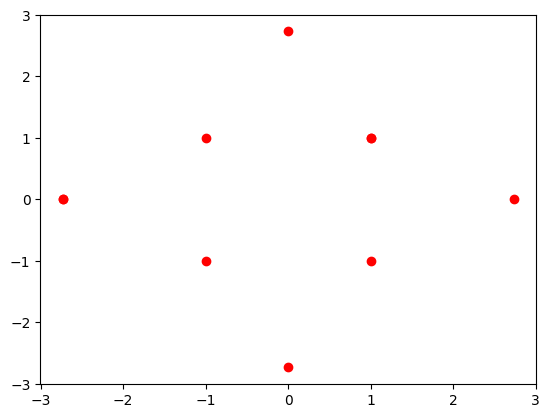

In [3]:
import matplotlib.pyplot as plt
import numpy as np
def modulate_8QAM(bit_sequence):
    if len(bit_sequence) % 3 != 0:
        raise ValueError("The length of the bit sequence must be a multiple of 3.")    
    constellation_points = {
        (0,0,0): 1+1j, 
        (0,0,1): -1+1j,
        (0,1,0): -1-1j, 
        (0,1,1): 1-1j,
        (1,0,0): 1+np.sqrt(3), 
        (1,0,1): 0+1j*(1+np.sqrt(3)), 
        (1,1,0): 0-1j*(1+np.sqrt(3)), 
        (1,1,1): -1-np.sqrt(3)
    }
    modulated_signal = []
    
    for i in range(0, len(bit_sequence), 3):
        bits = tuple(bit_sequence[i:i+3])
        modulated_signal.append(constellation_points[bits])
    
    return np.array(modulated_signal)
bit_sequence = np.array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,0,0,0,1,1,1,1,0,1,1,1,0])
symbols = modulate_8QAM(bit_sequence)
plt.scatter(symbols.real, symbols.imag, color='red')

## define some communication function

In [4]:
import math
import time
# 生成32000个星座图,对应32000个token
from tqdm import tqdm
from commpy.utilities import signal_power,dec2bitarray
from commpy.channels import awgn,SISOFlatChannel
import numpy as np
from commpy.modulation import QAMModem
M=8

#  token列表转换为bit序列，N为位宽
def token_to_bits(token: list, N: int):
    numbytes=[]
    [numbytes.extend(dec2bitarray(t,N).tolist()) for t in token]
    return np.array(numbytes)

# token转换为发射调制符号，
def token_tx(token: list):
  # 限制token值在0-32000范围内\
    vocab_size = 32000
    token = [min(t, vocab_size) for t in token]  
    # 将所有token转换为bit数组
    bits = token_to_bits(token, 15)  
    qam_symbols = modulate_8QAM(bits)
    return qam_symbols

# # 创建星座图
def creat_constellation(M,vocab_size=32000):
    # N = 2**(math.ceil(math.log2(math.ceil(math.log2(vocab_size)))))
    constellation = np.zeros([vocab_size,math.ceil(15/np.log2(M))],dtype = np.complex64)
    # print(token_tx([0],N).shape)
    for i in tqdm(range(vocab_size)):
        constellation[i,:] =  token_tx([i]) 
    return constellation


constellation = creat_constellation(M)
print(constellation.shape)

100%|██████████████████████████████████████████████████████████████████████████| 32000/32000 [00:00<00:00, 51232.46it/s]

(32000, 5)


## Define channel

In [5]:
from numpy.random import randn, random, standard_normal
class Channels():
    def __init__(self,snr_db):
        self.n_var = 4.70 / (10 ** (snr_db/ 10.0))
        self.snr_db = snr_db
    def AWGN(self,Tx_sig):
        # dims = len(Tx_sig)
        Rx_sig = [0] * len(Tx_sig)
        dims = next((i for i, x in enumerate(Tx_sig) if x == 0), len(Tx_sig))
        Rx_sig[:dims] = awgn(Tx_sig[:dims],self.snr_db)
        return Rx_sig
#     瑞丽信道,假设信道有完美的信道估计,所以此处返回H的值
    def Rayleigh(self,Tx_sig):
        Rx_sig = [0] * len(Tx_sig)
        nb_symb = next((i for i, x in enumerate(Tx_sig) if x == 0), len(Tx_sig))
        H = (standard_normal(nb_symb) + 1j * standard_normal(nb_symb)) * math.sqrt(0.5)
        # print(H.shape)
        Rx_sig[:nb_symb] = Tx_sig[:nb_symb] * H
        Rx_sig = self.AWGN(Rx_sig)
        Rx_sig[:nb_symb] = Rx_sig[:nb_symb]
        return Rx_sig,H
    def noise_std(self,):
        return self.n_var

## Rewrite 'generate' in GenerationMixin

In [6]:
from model_utils import CustomGenerationMixin
model.generate = CustomGenerationMixin.generate.__get__(model)
model._beam_search = CustomGenerationMixin._beam_search.__get__(model)
model.euclidean_distance_squared = CustomGenerationMixin.euclidean_distance_squared.__get__(model)

## some test

In [7]:
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from nltk.translate.bleu_score import sentence_bleu
start = time.time()
batch_size = 2
tx_tokens = tx_tokens[1:]
batch_sentences = tx_tokens[:batch_size]
padded_batch = pad_sequence(batch_sentences, batch_first=True)
print(padded_batch.shape)
start_ids = 5
lengths = torch.tensor([len(sentence) for sentence in batch_sentences])
transmitted_symbols = np.zeros([batch_size,(padded_batch.shape[1]-start_ids)*constellation.shape[1]],dtype = np.complex64)
received_symbols = np.zeros([batch_size,(padded_batch.shape[1]-start_ids)*constellation.shape[1]],dtype = np.complex64)
H = np.ones_like(received_symbols,dtype=np.complex64)
print('received_symbols shape:',received_symbols.shape)
M=8
N=15
snr_db = 6
channel =Channels(snr_db)
N0 = channel.noise_std()#/math.sqrt(0.5)
# print(padded_batch[1,1:])
for i in range(padded_batch.shape[0]):
    transmitted_symbols[i,0:(tx_tokens[i].shape[-1]-start_ids)*constellation.shape[1]] = token_tx(np.array(tx_tokens[i][start_ids:]))
    received_symbols[i,0:(tx_tokens[i].shape[-1]-start_ids)*constellation.shape[1]],H[i,0:(tx_tokens[i].shape[-1]-start_ids)*constellation.shape[1]] = channel.Rayleigh(transmitted_symbols[i,0:(tx_tokens[i].shape[-1]-start_ids)*constellation.shape[1]])
print(transmitted_symbols.shape)
power = signal_power(transmitted_symbols)
print('tx power:',power)

num_beams = 10
out_put = model.generate(padded_batch[:,0:start_ids].cuda(),received_symbols,constellation,M,N,N0,H,not_possible_tokens,num_beams = num_beams,do_sample = False, max_new_tokens = padded_batch.shape[1])
# # 
bleu_score = []
for i in range(out_put.shape[0]):
    rx_str = tokenizer.decode(out_put[i],
        skip_special_tokens=True,
        spaces_between_special_tokens=False,
        clean_up_tokenization_spaces=True,
        padding_side='left')
    tx_str = tokenizer.decode(tx_tokens[i],
        skip_special_tokens=True,
        spaces_between_special_tokens=False,
        clean_up_tokenization_spaces=True,
        padding_side='left')
    bleu_score.append(sentence_bleu([rx_str[0:len(tx_str)].split()],tx_str.split(),weights=(1,0,0,0)))
print('bleu:',bleu_score)
torch.cuda.empty_cache()
gc.collect()
print('used time:',time.time()-start)

torch.Size([2, 84])
received_symbols shape: (2, 395)
(2, 395)
tx power: 3.816978087541011
bleu: [0.8615384615384616, 0.9838709677419355]
used time: 6.744422435760498


FileNotFoundError: [Errno 2] No such file or directory: '../FastChat/data_com/Eurp.pkl'